# ATSC 500 Assignment IX (structure function)

In [2]:
import numpy as np
from numba import jit
from glob import glob
from matplotlib import pyplot as plt

% matplotlib inline

In [3]:
name = glob('_data/ATSC-500/aircraft.npz')
print(name)
data = np.load(name[0])
wvel = data['wvel']
wvel = wvel - np.mean(wvel)

['_data/ATSC-500/aircraft.npz']


$$
S_p = \frac{1}{N}\sum_{i=0}^{N}\left[f(x + L) - f(x)\right]^p
$$

where $L$ is a given constant.  

In [4]:
@jit(nopython=True)
def strfun(data, steps, p):
    """
    Imitated from https://clouds.eos.ubc.ca/~phil/courses/atsc500/html/strfun_fft.html
    """
    L = len(data)
    L2 = np.int32(L/2.)
    X = np.arange(1, L2)
    strfun = np.zeros(X.shape)
    count = np.zeros(X.shape)
    for str_ind, step in enumerate(X[:steps]):
        data_inds = np.arange(step, L2)
        for ind in data_inds:
            strfun[str_ind] += np.abs(data[ind] - data[ind - step])**p
            count[str_ind] += 1
        strfun[str_ind] = strfun[str_ind]/count[str_ind]
    return strfun[:steps]


In [9]:
L = 999
P = np.arange(2, 6)
xi = np.zeros(len(P))*np.nan
strfuns = np.zeros([L, len(P)])*np.nan
scaling = np.zeros([L, len(P)])*np.nan
K34scale = np.zeros([L, len(P)])*np.nan
X = np.arange(1, L+1)
for i, p in enumerate(P):
    strfuns[:, i] = strfun(wvel, L, p)
    xi[i], _, _, _ = np.linalg.lstsq(np.log(X).reshape(-1, 1), np.log(strfuns[:, i]/strfuns[0, i]).reshape(-1, 1))
    scaling[:, i] = strfuns[0, i]*X**(xi[i])
    K34scale[:, i] = strfuns[0, i]*X**(p/3)

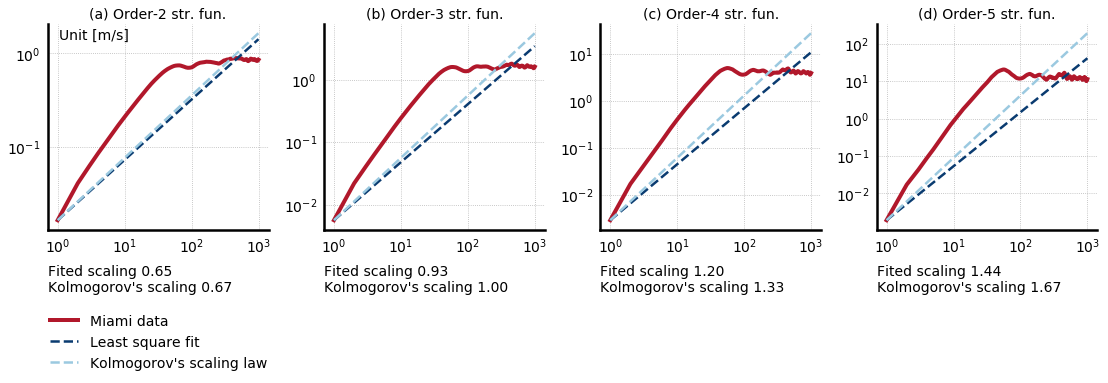

In [11]:
R1 = plt.cm.RdBu(25)
B1 = plt.cm.RdBu(250)
B2 = plt.cm.RdBu(175)

fig, AX = plt.subplots(1, len(P), figsize=(15.5, 3.75))
AX = AX.flat
strs = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(AX):
    ax.grid(linestyle=':')
    ax.spines["top"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    #ax.set_ylim([1e-4, 1e2])
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom="off", top="off", \
           labelbottom="on", left="off", right="off", labelleft="on")
    ax.set_title(strs[i]+' Order-{} str. fun.'.format(i+2), fontsize=14)
    ax.loglog(X, strfuns[:, i], '-', color=R1, lw=4, label='Miami data')
    ax.loglog(X, scaling[:, i], '--', color=B1, lw=2.5, label='Least square fit')
    ax.loglog(X, K34scale[:, i], '--', color=B2, lw=2.5, label="Kolmogorov's scaling law")
    ax.text(0, -0.3, "Fited scaling {:.2f}\nKolmogorov's scaling {:.2f}".format(xi[i], (i+2)/3), \
            fontsize=14, transform=ax.transAxes)
AX[0].text(0.05, 0.925, 'Unit [m/s]', fontsize=14, transform=AX[0].transAxes)
AX[0].spines["left"].set_visible(True)
AX[0].tick_params(labelleft="on")
LG = AX[0].legend(bbox_to_anchor=(1.05, -0.35), prop={'size':14}); LG.draw_frame(False)
plt.tight_layout()